# Оптимизация дальности стрельбы из артиллерийского орудия

# Варируя параметры заряжания и наведения обеспечить максимальную дальность стрельбы
## Решить методом:

1.1) Полный перебор

1.2) Скалярная оптимизация

1.3) Симплекс-метод (Нелдер-Мид)

1.4) Метод сопряженных направлений (Пауэлла)

1.5) Последовательное программирование методом наименьших квадратов (SLSQP)

## Система уравнений внешней баллистики
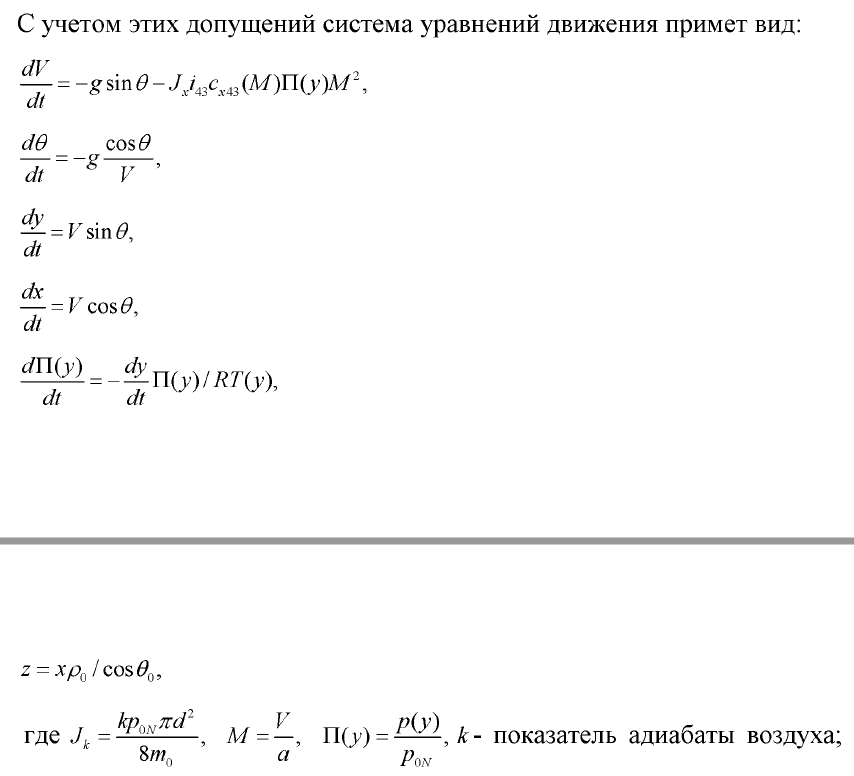

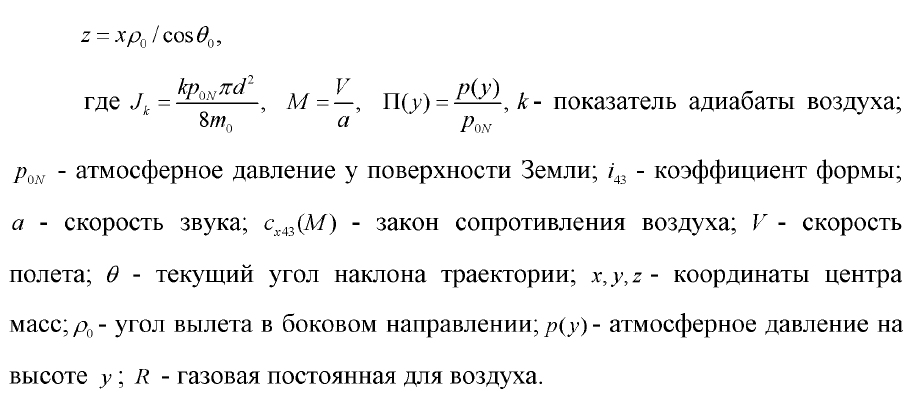

Возможные вариируемые параметры:

1) Начальная скорость (величина заряда)

2) Начальный угол бросания

Очевидно, что при большей начальной скорости, при прочих равных, максимальная дальность будет больше, однако опустим этот момент для практики решения задачи

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
from scipy.integrate import ode
from scipy.optimize import fsolve
import scipy.optimize
from tqdm import tqdm
import pandas as pd

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
matplotlib.rcParams.update({'font.size': 14})

In [2]:
#исходные данные
P_0N = 1.206 # плотность  на земле
tay_0N = 288.9 # температура на земле
p_0N = 0.99 * 10**5 # давление на земле
a_0N = 340.8 # скорость звука
g = 9.81 # ускор св пад
R = 287 # газов пост 
k = 1.24 # адиабата

In [3]:
# начальные данные аналог М-30 (52-Г-463)
d = 122/1000 # калибр
m_0 = 21.76 # масса
i_43N = 0.3 # коэф формы снаряда

In [4]:
# функция температуры от высоты
def tay(y):
    if y<=9300:
        return 286.9 - 0.006328*y
    elif (y>9300) and (y<=12000):
        return 230 - 0.006328*(y-9300) + 0.000001172*(y-9300)**2
    elif y>12000:
        return 221.5

In [5]:
# функция лобового сопротивления от скорости
def fun_c_x(v):
    M = v/a_0N
    if M<0.73:
        c_x = 0.157
    elif (M<0.82 and M>=0.73):
        c_x = 0.033*M+0.133
    elif (M<0.91 and M>=0.82):
        c_x = 0.161+3.9*(M-0.823)**2
    elif (M<1 and M>=0.91):
        c_x = 1.5*M-1.176
    elif (M<1.18 and M>=1):
        c_x = 0.384-1.6*(M-1.176)**2
    elif (M<1.62 and M>=1.18):
        c_x = 0.384*math.sin(1.85/M)
    elif (M<3.06 and M>=1.62):
        c_x = 0.29/M + 0.172
    elif (M<3.53 and M>=3.06):
        c_x = 0.316-0.016*M
    elif (M>=3.53):
        c_x = 0.259
        
    return c_x

In [6]:
# система уравнений внешней баллистики
def sistema(t, Y):
    
    v = Y[0]
    tetta = Y[1]
    y = Y[2]
    x = Y[3]
    P_ot_y = Y[4]
    
    dvdt = - k*p_0N*math.pi*d**2/(8*m_0) * i_43N * fun_c_x(v) * P_ot_y * (v/a_0N)**2 - g*math.sin(tetta)
    dtettadt = -g*math.cos(tetta)/v
    dydt = v*math.sin(tetta)
    dxdt = v*math.cos(tetta)
    dP_ot_ydt = -dydt * P_ot_y/(R*tay(y))
    
    return np.array([dvdt,dtettadt,dydt,dxdt,dP_ot_ydt])

In [7]:
def minimize_function(x,y):
    # начальные параметры
    v_0 = x
    tetta_0 = y
    t_0 = 0  # время
    x_0 = 0 # нач координата абсцисс
    y_0 = 0 # нач координата ординат
    P_ot_y_0 = 1 # отношение давлений на тек высоте к давлению на нулевой высоте

    # вектор начальных параметров
    Y_0 = [v_0,tetta_0,y_0,x_0,P_ot_y_0]

    # интегрирование методом "backward differentiation formulas"
    res = ode(sistema).set_integrator('vode', method='bdf')
    res.set_initial_value(Y_0, t_0)
    dt = 1e-1 # шаг по времени

    v_arr = [] # массив скоростей
    tetta_arr = [] # массив углов
    y_arr = [] # массив у
    x_arr = [] # массив х
    z_arr = [] # массив бокового отклонения
    P_ot_y_arr = [] # массив отнош давлений
    t_arr = [] # массив времени


    while (res.successful() and res.y[2] >= 0):
        v_arr.append(res.y[0])
        tetta_arr.append(res.y[1])
        y_arr.append(res.y[2])
        x_arr.append(res.y[3])
        P_ot_y_arr.append(res.y[4])
        t_arr.append(res.t+dt)
        a = (res.t+dt, res.integrate(res.t+dt))
        
    return -x_arr[-1]

Диапазон варьируемых параметров

In [8]:
v_0_min = 380
v_0_max = 515
tetta_0_min = 1/180 * np.pi
tetta_0_max = 63.3/180 * np.pi

Полный перебор

In [9]:
v_0_mas = np.linspace(v_0_min, v_0_max, 20)
tetta_0_mas = np.linspace(tetta_0_min, tetta_0_max, 20)

In [10]:
crit_mas = []
v_crit_mas = []
tetta_crit_mas = []
for i in tqdm(range(len(v_0_mas))):
    for j in range(len(tetta_0_mas)):
        crit_mas.append(abs(minimize_function(v_0_mas[i], tetta_0_mas[j])))
        v_crit_mas.append(v_0_mas[i])
        tetta_crit_mas.append(tetta_0_mas[j])

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.55it/s]


In [11]:
print('Максимальная дальность =',max(crit_mas))
print('Начальная скорость при максимальной дальности =',v_crit_mas[np.argmax(crit_mas)])
print('Начальная угол при максимальной дальности =',tetta_crit_mas[np.argmax(crit_mas)])

Максимальная дальность = 18154.765372672486
Начальная скорость при максимальной дальности = 515.0
Начальная угол при максимальной дальности = 0.761422851041105


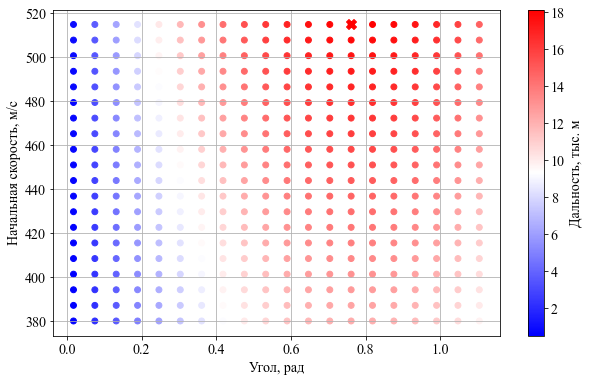

In [12]:
cm = plt.cm.get_cmap('bwr')
plt.figure(figsize=(10,6))
fig = plt.scatter(tetta_crit_mas,v_crit_mas, c=np.array(crit_mas)/1000, s=35, cmap=cm)
plt.scatter(tetta_crit_mas[np.argmax(crit_mas)],v_crit_mas[np.argmax(crit_mas)], s=100, marker='X', c='red')
plt.colorbar(fig, label='Дальность, тыс. м')
plt.xlabel('Угол, рад')
plt.ylabel('Начальная скорость, м/с')
plt.grid()

In [13]:
crit_pereb = max(crit_mas)
tetta_pereb = tetta_crit_mas[np.argmax(crit_mas)]
v_pereb = v_crit_mas[np.argmax(crit_mas)]

Скалярная оптимизация

Для этого изменим минимизируемую(оптимизируемую) функцию, значению скорости присвоим максимальное возможное значение

In [14]:
def minimize_function_scal(x):
    # начальные параметры
    v_0 = v_0_max
    tetta_0 = x
    t_0 = 0  # время
    x_0 = 0 # нач координата абсцисс
    y_0 = 0 # нач координата ординат
    P_ot_y_0 = 1 # отношение давлений на тек высоте к давлению на нулевой высоте

    # вектор начальных параметров
    Y_0 = [v_0,tetta_0,y_0,x_0,P_ot_y_0]

    # интегрирование методом "backward differentiation formulas"
    res = ode(sistema).set_integrator('vode', method='bdf')
    res.set_initial_value(Y_0, t_0)
    dt = 1e-1 # шаг по времени

    v_arr = [] # массив скоростей
    tetta_arr = [] # массив углов
    y_arr = [] # массив у
    x_arr = [] # массив х
    z_arr = [] # массив бокового отклонения
    P_ot_y_arr = [] # массив отнош давлений
    t_arr = [] # массив времени


    while (res.successful() and res.y[2] >= 0):
        v_arr.append(res.y[0])
        tetta_arr.append(res.y[1])
        y_arr.append(res.y[2])
        x_arr.append(res.y[3])
        P_ot_y_arr.append(res.y[4])
        t_arr.append(res.t+dt)
        a = (res.t+dt, res.integrate(res.t+dt))
        
    return -x_arr[-1]

In [15]:
res_scal = scipy.optimize.minimize_scalar(minimize_function_scal,method='brent')
res_scal

     fun: -18172.954943454766
    nfev: 35
     nit: 31
 success: True
       x: 0.7738047139158581

In [16]:
crit_scal = res_scal.fun
v_scal = v_0_max
tetta_scal = res_scal.x

In [17]:
print('Максимальная дальность =',-crit_scal)
print('Начальная скорость при максимальной дальности =',v_scal)
print('Начальная угол при максимальной дальности =',tetta_scal)

Максимальная дальность = 18172.954943454766
Начальная скорость при максимальной дальности = 515
Начальная угол при максимальной дальности = 0.7738047139158581


Симплекс-метод (Нелдер-Мид)

Меняем функцию под векторный вид

In [18]:
def minimize_function_vect(x):
    # начальные параметры
    v_0 = x[0]
    tetta_0 = x[1]
    t_0 = 0  # время
    x_0 = 0 # нач координата абсцисс
    y_0 = 0 # нач координата ординат
    P_ot_y_0 = 1 # отношение давлений на тек высоте к давлению на нулевой высоте

    # вектор начальных параметров
    Y_0 = [v_0,tetta_0,y_0,x_0,P_ot_y_0]

    # интегрирование методом "backward differentiation formulas"
    res = ode(sistema).set_integrator('vode', method='bdf')
    res.set_initial_value(Y_0, t_0)
    dt = 1e-1 # шаг по времени

    v_arr = [] # массив скоростей
    tetta_arr = [] # массив углов
    y_arr = [] # массив у
    x_arr = [] # массив х
    z_arr = [] # массив бокового отклонения
    P_ot_y_arr = [] # массив отнош давлений
    t_arr = [] # массив времени


    while (res.successful() and res.y[2] >= 0):
        v_arr.append(res.y[0])
        tetta_arr.append(res.y[1])
        y_arr.append(res.y[2])
        x_arr.append(res.y[3])
        P_ot_y_arr.append(res.y[4])
        t_arr.append(res.t+dt)
        a = (res.t+dt, res.integrate(res.t+dt))
        
    return -x_arr[-1]

In [19]:
bnds = ((v_0_min, v_0_max), (tetta_0_min, tetta_0_max)) # пределы изменения варьируемых параметров
start_point = ((v_0_min+v_0_max)/2, (tetta_0_min+tetta_0_max)/2) # стартовая точка

In [20]:
res_simp = scipy.optimize.minimize(minimize_function_vect, start_point, method='Nelder-Mead', bounds=bnds)

In [21]:
res_simp

 final_simplex: (array([[515.        ,   0.78015951],
       [515.        ,   0.78015951],
       [515.        ,   0.78015952]]), array([-18176.37837531, -18176.37837024, -18176.37832998]))
           fun: -18176.37837531128
       message: 'Optimization terminated successfully.'
          nfev: 105
           nit: 50
        status: 0
       success: True
             x: array([515.        ,   0.78015951])

In [22]:
crit_simp = res_simp.fun
v_simp = res_simp.x[0]
tetta_simp = res_simp.x[1]

In [23]:
print('Максимальная дальность =',-crit_simp)
print('Начальная скорость при максимальной дальности =',v_simp)
print('Начальная угол при максимальной дальности =',tetta_simp)

Максимальная дальность = 18176.37837531128
Начальная скорость при максимальной дальности = 515.0
Начальная угол при максимальной дальности = 0.7801595142921015


Метод сопряженных направлений (Пауэлла)

In [24]:
res_pow = scipy.optimize.minimize(minimize_function_vect, start_point, method='Powell', bounds=bnds)

In [25]:
res_pow

   direc: array([[ 0.        ,  1.        ],
       [-0.32682524, -0.00112266]])
     fun: -18160.224143398744
 message: 'Optimization terminated successfully.'
    nfev: 118
     nit: 2
  status: 0
 success: True
       x: array([514.66601378,   0.79348305])

In [26]:
crit_pow = res_pow.fun
v_pow = res_pow.x[0]
tetta_pow = res_pow.x[1]

In [27]:
print('Максимальная дальность =',-crit_pow)
print('Начальная скорость при максимальной дальности =',v_pow)
print('Начальная угол при максимальной дальности =',tetta_pow)

Максимальная дальность = 18160.224143398744
Начальная скорость при максимальной дальности = 514.6660137753535
Начальная угол при максимальной дальности = 0.7934830478818219


Последовательное программирование методом наименьших квадратов (SLSQP)

In [28]:
res_sl = scipy.optimize.minimize(minimize_function_vect, start_point, method='SLSQP', bounds=bnds)

In [29]:
res_sl

     fun: -13775.280832297776
     jac: array([-103.94091797, 5959.51843262])
 message: 'Optimization terminated successfully'
    nfev: 31
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([447.34255076,   0.55982028])

In [30]:
crit_sl = res_sl.fun
v_sl = res_sl.x[0]
tetta_sl = res_sl.x[1]

In [31]:
print('Максимальная дальность =',-crit_sl)
print('Начальная скорость при максимальной дальности =',v_sl)
print('Начальная угол при максимальной дальности =',tetta_sl)

Максимальная дальность = 13775.280832297776
Начальная скорость при максимальной дальности = 447.34255075533554
Начальная угол при максимальной дальности = 0.5598202833803689


Приведем к одной таблице

In [32]:
df = pd.DataFrame({
    'criterion':[-crit_pereb, crit_scal, crit_simp, crit_pow, crit_sl],
    'v': [v_pereb, v_scal, v_simp, v_pow, v_sl],
    'tetta': [tetta_pereb, tetta_scal, tetta_simp, tetta_pow, tetta_sl], 
    'description':['Перебор', 'Скаляр', 'Симплекс', 'Пауэлл', 'SLSQP']
})
df.criterion = df.criterion * (-1)

In [33]:
df

,criterion,v,tetta,description
0,18154.765373,515.000000,0.761423,Перебор
1,18172.954943,515.000000,0.773805,Скаляр
2,18176.378375,515.000000,0.780160,Симплекс
3,18160.224143,514.666014,0.793483,Пауэлл
4,13775.280832,447.342551,0.559820,SLSQP


In [34]:
df = df.sort_values('criterion', ascending=False)
df

,criterion,v,tetta,description
2,18176.378375,515.000000,0.780160,Симплекс
1,18172.954943,515.000000,0.773805,Скаляр
3,18160.224143,514.666014,0.793483,Пауэлл
0,18154.765373,515.000000,0.761423,Перебор
4,13775.280832,447.342551,0.559820,SLSQP


Лучший результат расчета - симплекс метод, примем его за эталон, посчитаем ошибку в процентах

In [35]:
crit_etalon = df.criterion[df.criterion.idxmax()]
v_etalon = df.v[df.criterion.idxmax()]
tetta_etalon = df.tetta[df.criterion.idxmax()]

In [36]:
df['v_diff_percent'] = abs((df.v-v_etalon))/v_etalon * 100
df['tetta_diff_percent'] = abs((df.tetta-tetta_etalon))/tetta_etalon * 100

In [37]:
df

,criterion,v,tetta,description,v_diff_percent,tetta_diff_percent
2,18176.378375,515.000000,0.780160,Симплекс,0.000000,0.000000
1,18172.954943,515.000000,0.773805,Скаляр,0.000000,0.814551
3,18160.224143,514.666014,0.793483,Пауэлл,0.064852,1.707796
0,18154.765373,515.000000,0.761423,Перебор,0.000000,2.401645
4,13775.280832,447.342551,0.559820,SLSQP,13.137369,28.242844


Наименее точным методом оказался метод последовательного программирования методом наименьших квадратов (SLSQP), перебор несмотря на свою простоту ошибся в расчете угла на 2.4 %

Точность перебора можно увеличить увеличивая сетку разбиения и вводя доп. исследование окрестности максимума

Точность методов оптимизации можно увеличить смещением начальной точки и увеличением количества итераций